# Objetivo
Prever sobreviventes da tragédia do titanic

## Importing libs

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import researchpy as rp
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.impute import KNNImputer
from pycaret import classification
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

## Importing data

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3.0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3.0,"Heikkinen, Miss. Laina",women,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female_,35.0,1,0,113803,53.1000,C123,S
4,5,0,3.0,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Modificar as colunas para caixa baixa para padronizar as colunas de ambos datasets

In [6]:
df_test.columns = df_test.columns.str.lower()

## Utils

In [7]:
def chisquare(df, index, col, figsize=(10, 4), annot=True):
    '''
    plot contingency table and chi-square statistics for two categorical variables
    '''
    table, results = rp.crosstab(df_train[index], df_train[col], test='chi-square')
    plt.figure(figsize=figsize)
    sns.heatmap(table.iloc[:-1,:-1], cmap='viridis', annot=annot, fmt='.4g', cbar=False)
    plt.show()
    print(results)

## EDA

### 1) Passenger ID

Avaliando se existem passageiros duplicados na base e deletando-os, assim como a coluna `passengerid`

In [8]:
df_train['passengerid'].duplicated().sum()

45

In [9]:
df_train.drop_duplicates(inplace=True)

In [10]:
df_train['passengerid'].duplicated().sum()

0

In [11]:
def drop_cols(df, cols):
    '''
    Return dataset without selected columns
    '''
    return df.drop(cols, axis=1)

In [12]:
df_train = drop_cols(df_train, 'passengerid')
df_test = drop_cols(df_test, 'passengerid')

### 2) General analysis

Análise geral observando a proporção de sobreviventes e valores faltantes

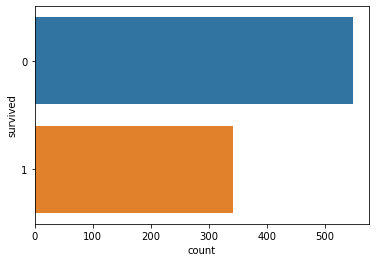

In [13]:
sns.countplot(data=df_train, y='survived');

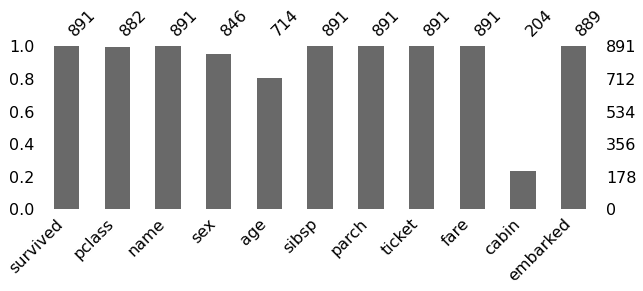

In [14]:
msno.bar(df_train, figsize=(10, 3));

### 3) Pclass

Temos 9 valores faltantes de classe de passagem

In [15]:
df_train['pclass'].isnull().sum()

9

Classe 3 tem maior volumetria e menor índice de sobreviventes

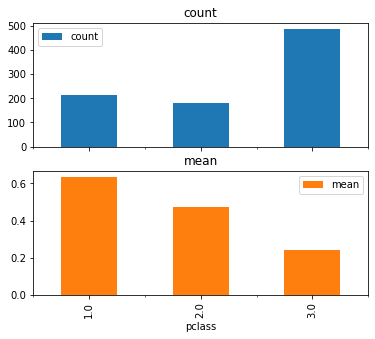

In [16]:
df_train.groupby('pclass')['survived'].agg(['count', 'mean']).plot(kind='bar', subplots=True, figsize=(6, 5));

Classe da passagem costuma estar relacionada com o valor da passagem, observando pelos gráficos abaixo podemos observar o valor para cada classe

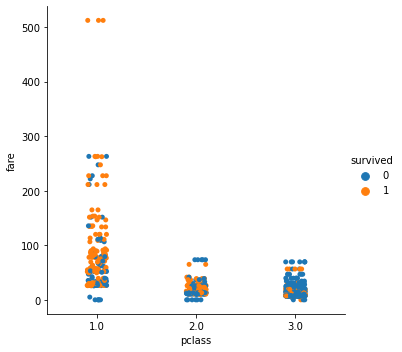

In [20]:
sns.catplot(data=df_train, x='pclass', y='fare', hue='survived');

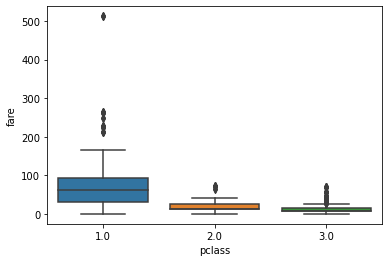

In [21]:
sns.boxplot(data=df_train, x='pclass', y='fare')

In [22]:
df_train.groupby('pclass')['fare'].max()

pclass
1.0    512.3292
2.0     73.5000
3.0     69.5500
Name: fare, dtype: float64

Dessa forma, podemos observar que qualquer passagem que foi paga acima de `73.5` com certeza é da 1ª classe

In [23]:
df_train.loc[(df_train['pclass'].isnull())&
             (df_train['fare'] > 73.5), 'pclass'] = 1

Preencherei o restante das classes faltantes com a classe mais frequente

In [24]:
df_train['pclass'].fillna(df_train['pclass'].mode()[0], inplace=True)

In [25]:
df_train['pclass'] = df_train['pclass'].astype('int8')

P-valor é próximo de zero, então temos rejeitar a hipótese nula de independência entre as variáveis e inferir que existe dependência entre entre classe e sobreviventes. De acordo com o V de Cramer, a força dessa relação é de 0.34

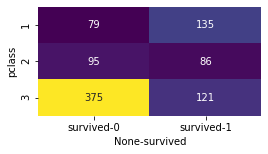

                Chi-square test   results
0  Pearson Chi-square ( 2.0) =   102.6223
1                    p-value =     0.0000
2                 Cramer's V =     0.3394


In [26]:
chisquare(df_train, 'pclass', 'survived', figsize=(4, 2))

### 4) Name and Sex

Os pronomes de tratamento `title` no nome dos passageiros podem ajudar a prever sobreviventes

In [27]:
def sub(s):
    start = s.find(", ") + len(", ")
    end = s.find(". ")
    return s[start:end]

In [28]:
df_train['title'] = df_train['name'].apply(lambda s: sub(s))
df_test['title'] = df_test['name'].apply(lambda s: sub(s))

Antes de prosseguir com a análise dos pronomes de tratamento, nota-se que os valores da variável `sex` não estão padronizados

In [29]:
df_train['sex'].value_counts()

male         137
Male          82
man           82
mal           82
 male         82
male          82
female        75
Female        45
 female       45
woman         45
female_       45
women         44
Name: sex, dtype: int64

Embora os valores da base de teste estão padronizados

In [30]:
df_test['sex'].value_counts()

male      266
female    152
Name: sex, dtype: int64

Dessa forma, utilizarei os `titles` para inferir se o passageiro é homem ou mulher

In [31]:
df_train.loc[(df_train['sex'].isnull()) & (df_train['title'].isin(['Major', 'Master', 'Mr'])),'sex'] = 'male'
df_train.loc[(df_train['sex'].isnull()) & (df_train['title'].isin(['Miss', 'Mrs', 'the Countess'])),'sex'] = 'female'
df_train['sex'] = df_train['sex'].str.lower()
df_train.loc[(df_train['sex'].str.contains('female')) | 
             (df_train['sex'].str.contains('wom')), 'sex'] = 'female'
df_train.loc[~df_train['sex'].str.contains('female'), 'sex'] = 'male'
df_train['sex'].value_counts()

male      577
female    314
Name: sex, dtype: int64

Podemos observar a tabela de frequencia que alguns títulos são comuns para ambos os sexos

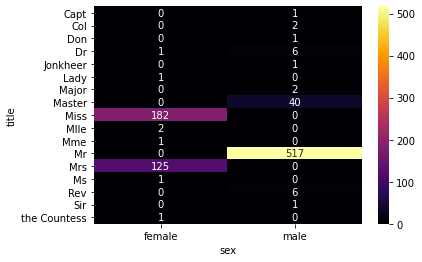

In [32]:
sns.heatmap(pd.crosstab(df_train['title'], df_train['sex']), annot=True, fmt='.4g', cmap='inferno');

Proseguindo com a análise de correlação, temos o `title` tem uma forte relação com o índice de sobrevivência

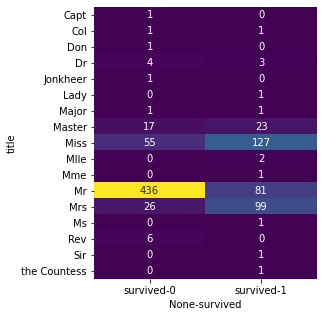

                 Chi-square test   results
0  Pearson Chi-square ( 16.0) =   300.0230
1                     p-value =     0.0000
2                  Cramer's V =     0.5803


In [33]:
chisquare(df_train, 'title', 'survived', figsize=(4, 5))

No entanto, utilizar todos os títulos pode deixar a matriz de variáveis muito esparsa, além de que tem `titles` que não tem volumetria expressiva. Dessa forma coletei somente os 3 maiores `titles` e nomeei o restante de `other`. Ainda assim, essa variável reduzida `title_top` possue forte relação com `survived`

In [34]:
def top_title(df, top=3):
    top_title = df['title'].value_counts().head(top).index
    df['title_top'] = df['title'].where(df['title'].isin(top_title), other='other')
    return df

In [35]:
df_train = top_title(df_train)
df_test = top_title(df_test)

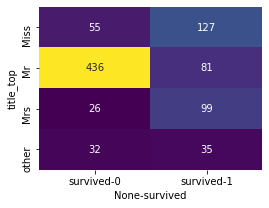

                Chi-square test   results
0  Pearson Chi-square ( 3.0) =   282.1498
1                    p-value =     0.0000
2                 Cramer's V =     0.5627


In [36]:
chisquare(df_train, 'title_top', 'survived', figsize=(4, 3))

Assim como `sex` tem forte correlação com `survived`

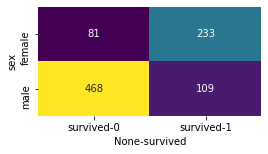

                Chi-square test   results
0  Pearson Chi-square ( 1.0) =   263.0506
1                    p-value =     0.0000
2               Cramer's phi =     0.5434


In [37]:
chisquare(df_train, 'sex', 'survived', figsize=(4, 2))

Eliminarei essas colunas que não irão contribuir na predição 

In [38]:
df_train = drop_cols(df_train, ['name', 'title'])
df_test = drop_cols(df_test, ['name', 'title'])

### 5) Age

Podemos observar a distribuição da idade para sobreviventes e não sobreviventes

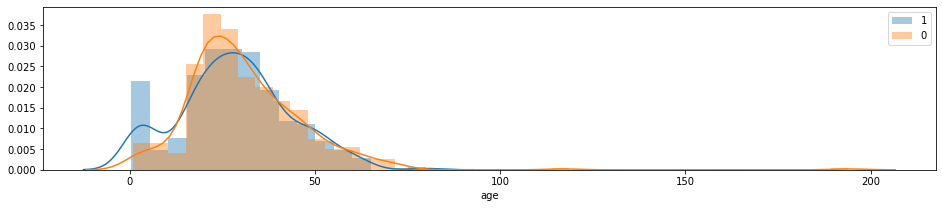

In [40]:
plt.figure(figsize=(16, 3))
sns.distplot(df_train[df_train['survived']==1]['age'], label=1)
sns.distplot(df_train[df_train['survived']==0]['age'], label=0)
plt.legend()
plt.show()

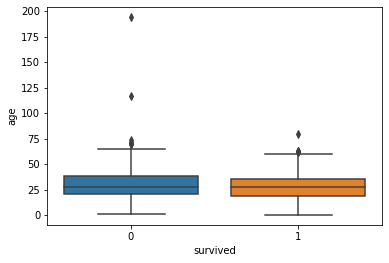

In [41]:
sns.boxplot(data=df_train, y='age', x='survived');

Apenas pela distribuição, talvez não ficou muito claro se idade auxilia na previsão de sobreviventes, então podemos tentar construir alguns modelos simples para tentar enxergar essa relação

In [42]:
age_survived = df_train[['age', 'survived']].dropna()
x, y = age_survived[['age']], age_survived['survived']

Pela regressão logística, podemos observar que quanto mais jovem, maior a probabilidade de sobrevivência, ainda que essa probabilidade nunca será maior que `0.5`

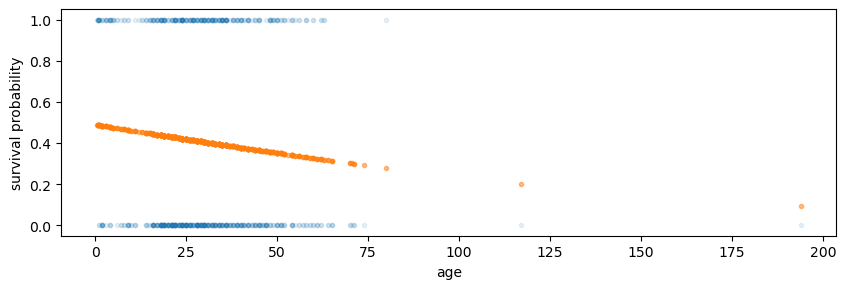

In [43]:
lr = LogisticRegression()
lr.fit(x, y)
y_pred = lr.predict_proba(x)[:, 1]

plt.figure(figsize = (10, 3), dpi = 100)
plt.plot(x, y, '.', alpha = 0.1)
plt.plot(x, y_pred, '.', alpha = 0.5)
plt.xlabel('age')
plt.ylabel('survival probability')
plt.show()

Pela árvore de decisão podemos observar a quebra de idades para previsão. Como idade tem bastante valores faltantes, deixarei para preenchê-los ao final da análise

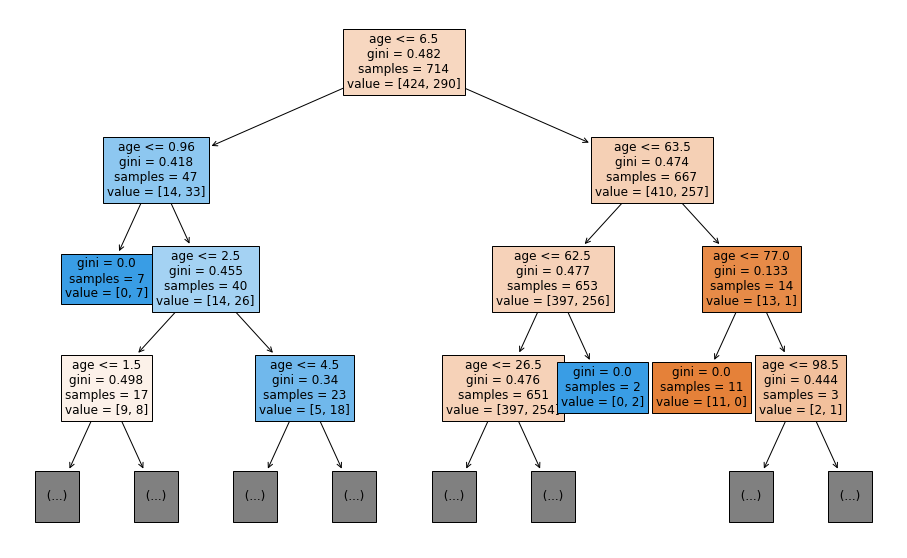

In [44]:
dt = DecisionTreeClassifier()

dt.fit(x, y)

plt.figure(figsize=(16, 10))
plot_tree(dt, max_depth=3, feature_names=['age'], filled=True, fontsize=12)
plt.show()

### 6) Sibsp and Parch

Podemos observar que passageiros com poucos irmão/companheiros costumam ter poucos parentes e filhos à bordo; e ambas variáveis tem correlação com sobreviventes

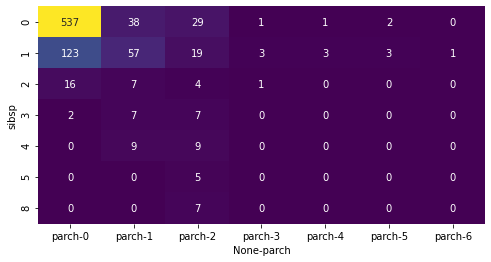

                 Chi-square test   results
0  Pearson Chi-square ( 36.0) =   341.6820
1                     p-value =     0.0000
2                  Cramer's V =     0.2528


In [45]:
chisquare(df_train, 'sibsp', 'parch', figsize=(8, 4))

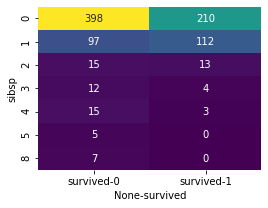

                Chi-square test  results
0  Pearson Chi-square ( 6.0) =   37.2718
1                    p-value =    0.0000
2                 Cramer's V =    0.2045


In [46]:
chisquare(df_train, 'sibsp', 'survived', figsize=(4, 3))

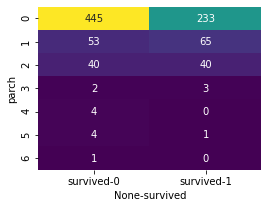

                Chi-square test  results
0  Pearson Chi-square ( 6.0) =   27.9258
1                    p-value =    0.0001
2                 Cramer's V =    0.1770


In [47]:
chisquare(df_train, 'parch', 'survived', figsize=(4, 3))

Abaixo podemos observar a taxa de sobreviventes e volumetria para cada par `parch` e `sibsp`

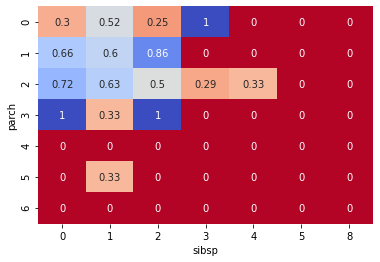

In [48]:
sns.heatmap(pd.pivot_table(df_train, 'survived', 'parch', 'sibsp', aggfunc='mean', fill_value=0),
            annot=True, cmap='coolwarm_r', cbar=False);

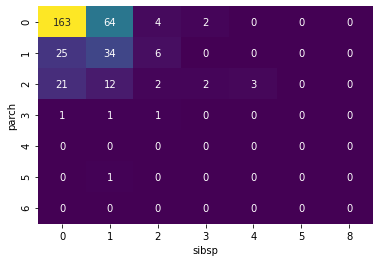

In [49]:
sns.heatmap(pd.pivot_table(df_train, 'survived', 'parch', 'sibsp', aggfunc='sum', fill_value=0),
            annot=True, cmap='viridis', cbar=False, fmt='.3g');

### 7) Ticket and Cabin

Pelas variáveis `ticket` e `cabin`, não podemos dizer que com 99% de confiança que rejeitamos a hipótese nula, além de que ambas tem baixa volumetria de passageiros, portanto serão eliminadas do modelo

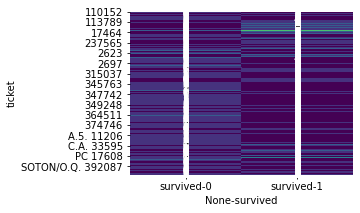

                  Chi-square test   results
0  Pearson Chi-square ( 680.0) =   766.5697
1                      p-value =     0.0115
2                   Cramer's V =     0.9275


In [50]:
chisquare(df_train, 'ticket', 'survived', figsize=(4, 3))

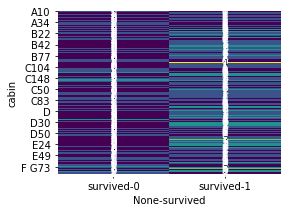

                  Chi-square test   results
0  Pearson Chi-square ( 146.0) =   161.2500
1                      p-value =     0.1836
2                   Cramer's V =     0.8891


In [51]:
chisquare(df_train, 'cabin', 'survived', figsize=(4, 3))

In [52]:
df_train = drop_cols(df_train, ['ticket', 'cabin'])
df_test = drop_cols(df_test, ['ticket', 'cabin'])

### 8) Fare

Observando a distribuição do valor da passagem, notamos uma distribuição assímetrica

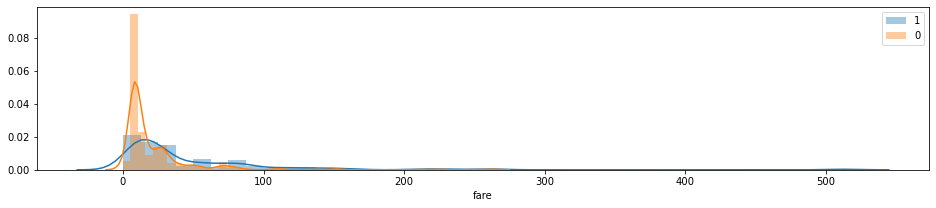

In [53]:
plt.figure(figsize=(16, 3))
sns.distplot(df_train[df_train['survived']==1]['fare'], label=1)
sns.distplot(df_train[df_train['survived']==0]['fare'], label=0)
plt.legend()
plt.show()

Aplicarei o log para deixá-la mais uniforme

In [54]:
df_train['fare_log'] = np.log(df_train['fare'])
df_train['fare_log'][df_train['fare_log'] == -np.inf] = 0

C:\Users\milto\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\milto\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


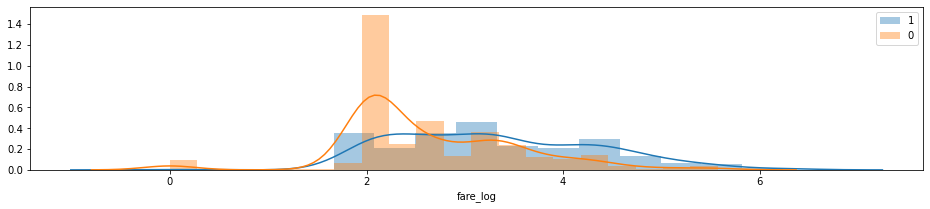

In [55]:
plt.figure(figsize=(16, 3))
sns.distplot(df_train[df_train['survived']==1]['fare_log'], label=1)
sns.distplot(df_train[df_train['survived']==0]['fare_log'], label=0)
plt.legend()
plt.show()

E aplicarei um modelo simples `regressão logística` para avaliar se faz sentido usá-la pura ou com transformação logarítimica

In [56]:
fare_survived = df_train[['fare', 'fare_log', 'survived']].dropna()
x, x_log, y = fare_survived[['fare']], fare_survived[['fare_log']], fare_survived['survived']

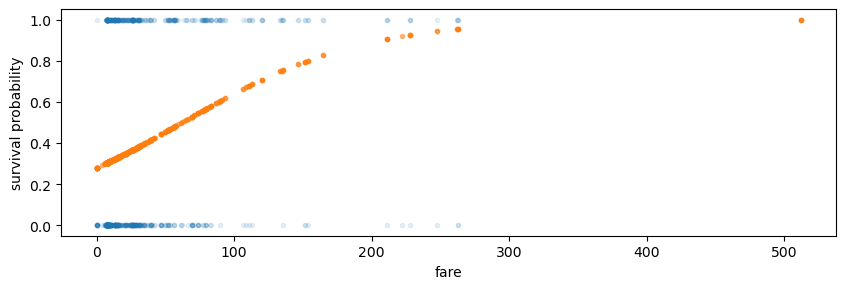

In [57]:
lr = LogisticRegression()
lr.fit(x, y)
y_pred = lr.predict_proba(x)[:, 1]

plt.figure(figsize = (10, 3), dpi = 100)
plt.plot(x, y, '.', alpha = 0.1)
plt.plot(x, y_pred, '.', alpha = 0.5)
plt.xlabel('fare')
plt.ylabel('survival probability')
plt.show()

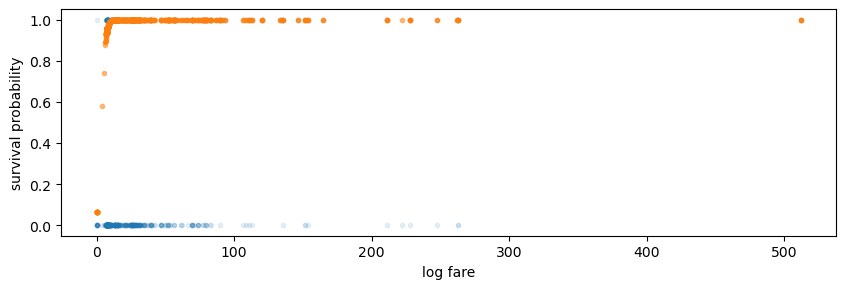

In [58]:
lr = LogisticRegression()
lr.fit(x_log, y)
y_pred = lr.predict_proba(x)[:, 1]

plt.figure(figsize = (10, 3), dpi = 100)
plt.plot(x, y, '.', alpha = 0.1)
plt.plot(x, y_pred, '.', alpha = 0.5)
plt.xlabel('log fare')
plt.ylabel('survival probability')
plt.show()

In [59]:
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm

In [60]:
x = sm.add_constant(x)
x_log = sm.add_constant(x_log)

In [61]:
lr = GLM(y, x, family=sm.families.Binomial()).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      889
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -558.78
Date:                Wed, 10 Jun 2020   Deviance:                       1117.6
Time:                        21:15:31   Pearson chi2:                     934.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9413      0.095     -9.895      0.000      -1.128      -0.755
fare           0.0152      0.002      6.809      0.000       0.011       0.020
==============================================================================
"""

In [62]:
lr = GLM(y, x_log, family=sm.families.Binomial()).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      889
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -542.23
Date:                Wed, 10 Jun 2020   Deviance:                       1084.5
Time:                        21:15:31   Pearson chi2:                     888.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6803      0.249    -10.762      0.000      -3.168      -2.192
fare_log       0.7472      0.080      9.366      0.000       0.591       0.904
==============================================================================
"""

Pelo pearsor chi2 a transformação não melhorou o modelo, logo usarei-a sem transformação

In [63]:
df_train = drop_cols(df_train, 'fare_log')

### 9) Embarked

O local do embarque parece que tem baixa relação com o índice de sobreviventes. Deixarei-a no modelo, preenchendo valores faltantes pelo local mais frequente

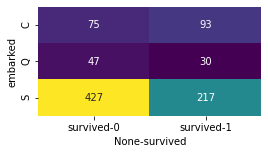

                Chi-square test  results
0  Pearson Chi-square ( 2.0) =   26.4891
1                    p-value =    0.0000
2                 Cramer's V =    0.1726


In [64]:
chisquare(df_train, 'embarked', 'survived', figsize=(4, 2))

In [65]:
df_train['embarked'].fillna(df_train['embarked'].mode()[0], inplace=True)

## Dataprep

Com os dados prontos, aplicarei one-hot-encoding (dummies) para criar uma coluna para cada variável categórica

In [109]:
df_train_d = pd.get_dummies(df_train, drop_first=True)
df_test_d = pd.get_dummies(df_test, drop_first=True)

Em seguida usarei KNN para imputar idade dos passageiros baseados em outros passageiros similares

In [111]:
imputer = KNNImputer(weights='distance')

In [112]:
age_imputer = imputer.fit_transform(df_train_d)[:,2].astype(int)

In [113]:
df_train_d['age'] = age_imputer

## Model

Fazendo setup dos dados para modelagem

In [118]:
clf_setup = classification.setup(df_train_d, 'survived',
                                 numeric_features=['pclass', 'age', 'sibsp', 'parch',
                                                   'fare', 'sex_male','embarked_Q', 'embarked_S',
                                                   'title_top_Mr', 'title_top_Mrs','title_top_other'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,8748
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(891, 12)"
4,Missing Values,False
5,Numeric Features,11
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Ao aplicar diferentes classificadores, notamos que o `catboost` obteve a maior acurácia na validação cruzada de 10 pastas

In [119]:
classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.837900,0.884100,0.740000,0.825200,0.777000,0.650500
1,Random Forest Classifier,0.829800,0.878400,0.740200,0.806800,0.769500,0.635100
2,Gradient Boosting Classifier,0.820300,0.883300,0.714900,0.799000,0.752000,0.611900
3,Extreme Gradient Boosting,0.818700,0.889100,0.706700,0.810400,0.749900,0.608900
4,Light Gradient Boosting Machine,0.818600,0.880400,0.723700,0.791200,0.753100,0.610500
5,Extra Trees Classifier,0.813800,0.868100,0.740200,0.772200,0.752800,0.603700
6,Logistic Regression,0.807500,0.866000,0.731500,0.769900,0.743900,0.590400
7,Decision Tree Classifier,0.792800,0.779300,0.723400,0.741600,0.728300,0.561200
8,Ridge Classifier,0.791400,0.000000,0.719200,0.746200,0.726600,0.558800
9,Linear Discriminant Analysis,0.789800,0.869400,0.719200,0.742200,0.724900,0.555600


Dessa forma, utilizarei o `catboost` para tunar seus hiperparâmetros e obter o melhor classificador, metrificando pela acurácia

In [120]:
clf_cboost = classification.tune_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8254,0.8579,0.7500,0.7826,0.7660,0.6268
1,0.8571,0.9156,0.8333,0.8000,0.8163,0.6995
2,0.7937,0.8440,0.7500,0.7200,0.7347,0.5660
3,0.8065,0.8261,0.5652,0.8667,0.6842,0.5534
4,0.8548,0.9024,0.7917,0.8261,0.8085,0.6917
5,0.8548,0.9134,0.7083,0.8947,0.7907,0.6819
6,0.8226,0.9013,0.8333,0.7407,0.7843,0.6345
7,0.8710,0.8991,0.7500,0.9000,0.8182,0.7195
8,0.8548,0.8871,0.7500,0.8571,0.8000,0.6869
9,0.7742,0.8629,0.6667,0.7273,0.6957,0.5167


## Results

Podemos visualizar a matriz de confusão do `catboost` na base de treino

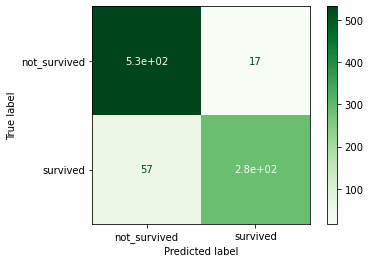

In [140]:
plot_confusion_matrix(clf_cboost, df_train_d.drop('survived', axis=1), df_train_d['survived'],
                      display_labels=['not_survived', 'survived'], cmap='Greens', values_format='.0g');

Abaixo temos os shap values do `catboost`, indicando, de uma forma generalizada, quais variáveis estão sendo mais importantes para a predição

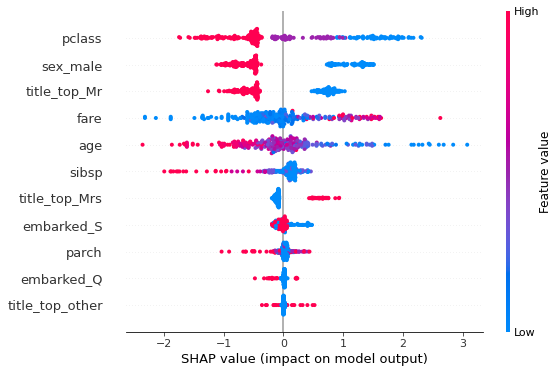

In [141]:
classification.interpret_model(clf_cboost, plot='summary')

Podemos observar a correlação entre algumas variáveis para prever os sobreviventes

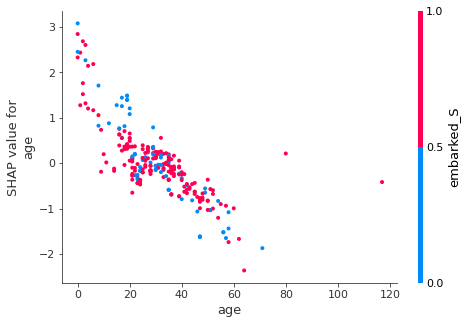

In [143]:
classification.interpret_model(clf_cboost, plot='correlation', feature='age')

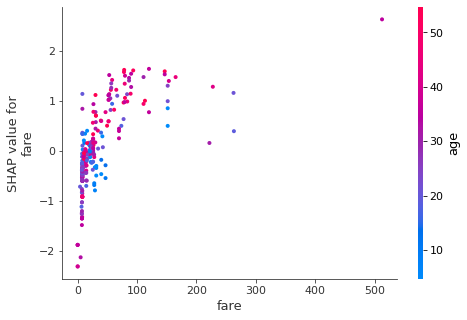

In [144]:
classification.interpret_model(clf_cboost, plot='correlation', feature='fare')

## Predicting

Por fim, podemos utilizar o melhor classificador para criar uma probabilidade do passageiro sobreviver na base de teste

In [148]:
df_test_d['survived_proba'] = clf_cboost.predict_proba(df_test_d)[:,1]

In [149]:
df_test_d.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,title_top_Mr,title_top_Mrs,title_top_other,survived_proba
0,3,34.5,0,0,7.8292,1,1,0,1,0,0,0.034002
1,3,47.0,1,0,7.0000,0,0,1,0,1,0,0.022697
2,2,62.0,0,0,9.6875,1,1,0,1,0,0,0.012523
3,3,27.0,0,0,8.6625,1,0,1,1,0,0,0.134524
4,3,22.0,1,1,12.2875,0,0,1,0,1,0,0.319586
